# Data Mining Challange: *Reddit Gender Classification*

## Modules

In [6]:
# Numpy & matplotlib for notebooks 
%pylab inline

# Pandas for data analysis and manipulation 
import pandas as pd 

# Sparse matrix package for numeric data.
from scipy import sparse

# Module for word embedding (word2vector)
import gensim  

# Module for progress monitoring
import tqdm   

# Sklearn 
from sklearn.preprocessing import StandardScaler # to standardize features by removing the mean and scaling to unit variance (z=(x-u)/s)
from sklearn.neural_network import MLPClassifier # Multi-layer Perceptron classifier which optimizes the log-loss function using LBFGS or sdg.
from sklearn.model_selection import train_test_split # to split arrays or matrices into random train and test subsets
from sklearn.model_selection import KFold # K-Folds cross-validator providing train/test indices to split data in train/test sets. 

Populating the interactive namespace from numpy and matplotlib


## Data Collection 

In [7]:
# Import the training dataset
train_data = pd.read_csv("data/train_data.csv", encoding="utf8") 

# Import the training target
train_target = pd.read_csv("data/train_target.csv") 

## Feature Extraction

In [8]:
# Crate a features dictionary
features = {}  

# Index unique subreddits/topics 

subreddits = train_data.subreddit.unique()   
subreddits_series = pd.Series(index=subreddits, data=arange(subreddits.shape[0])) 

# Define a function to extract features from categorical data and store them in a CSR matrix
def extract_features(category): 
    # np.array of subreddit labels 
    labels = subreddits_series[category['subreddit'].values].values        
    # construct a  (1)x(#subreddits) sparse matrix incrementally
    sparse_matrix = sparse.dok_matrix((1, subreddits.shape[0]))
    # for all NaN labels assign 1 to sparse_matrix
    for label in labels:
        if not np.isnan(label): 
            sparse_matrix[0, label] = 1
    # convert in CSR format 
    return sparse_matrix.tocsr()

In [9]:
# Populate the features dictionary with keys ("authors") and values ("sparse_matrix")
for author, category in train_data.groupby('author'):
    features[author] = extract_features(category) 

In [62]:
# Vertically stack features by (target) author and store in X
X = sparse.vstack([features[author] for author in train_target.author])

# Vertically stack gender by (target) author and store in Y
y = train_target.gender

In [63]:
X_array = X.toarray()
X = np.array(list(map(np.array, X_array)))     
y = np.array(list(map(np.array, y)))
# map(function_to_apply, list_of_inputs) --> applies a function to all the items in an input_list

seed = 2000
x_train , x_validation, y_train , y_validation = train_test_split(X, y, test_size = 1000, random_state = seed)

Exception: Data must be 1-dimensional

## Model Selection: *Multi-Layer Perceptron (MLP)*

### Model Training & Validation

In [35]:
model = MLPClassifier(hidden_layer_sizes= (100,), activation= "relu", solver= "adam",
                      alpha= 0.05, learning_rate= "invscaling", learning_rate_init= 0.001,
                      max_iter= 300, shuffle= True, tol= 1e-4, warm_start= False,
                      early_stopping = True, verbose = True, n_iter_no_change= 10)

# K fold per la cross-validation
kf = KFold(n_splits = 10)

# alleamento e validazione su tutti i KFold
for train_indices, test_indices in kf.split(x_train):
    model.fit(x_train[train_indices], y_train[train_indices])
    print(model.score(x_train[test_indices], y_train[test_indices]))

Iteration 1, loss = 0.65086519
Validation score: 0.755556
Iteration 2, loss = 0.52634454
Validation score: 0.791667
Iteration 3, loss = 0.44994859
Validation score: 0.833333
Iteration 4, loss = 0.38497233
Validation score: 0.850000
Iteration 5, loss = 0.33788703
Validation score: 0.852778
Iteration 6, loss = 0.30322055
Validation score: 0.850000
Iteration 7, loss = 0.27860353
Validation score: 0.852778
Iteration 8, loss = 0.26017567
Validation score: 0.850000
Iteration 9, loss = 0.24558483
Validation score: 0.841667
Iteration 10, loss = 0.23425198
Validation score: 0.838889
Iteration 11, loss = 0.22497539
Validation score: 0.836111
Iteration 12, loss = 0.21728931
Validation score: 0.830556
Iteration 13, loss = 0.21014437
Validation score: 0.830556
Iteration 14, loss = 0.20376485
Validation score: 0.830556
Iteration 15, loss = 0.19867613
Validation score: 0.833333
Iteration 16, loss = 0.19457393
Validation score: 0.836111
Validation score did not improve more than tol=0.000100 for 10 co

In [36]:
y_score = model.predict_proba(x_validation)[:,1]

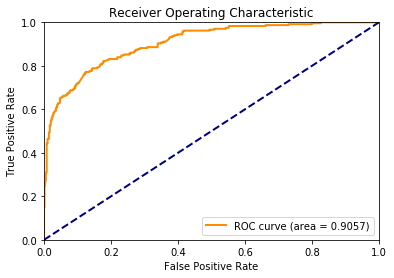

In [37]:
# ROC Curve for data validation 
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_validation, y_score)
roc_auc = auc(fpr, tpr) 

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Logistic Regression 

In [30]:
#creo il dataframe con i risultati dell'analisidel subreddit:

scoreXSparse = pd.DataFrame({"y_validation":y_validation, "XSparseGender":y_score})
scoreXSparse.to_csv('scoreXSparseValidation.csv')

In [31]:
#vado a riprendere i risultati dell'analisi dei subreddit
scoreXSparse = pd.read_csv('scoreXSparseValidation.csv', index_col = 0)

In [32]:
#risultati dell'analisi dei W2V
scoreW2V = pd.read_csv('scoreW2VAugvalidation.csv', index_col= 0)

In [33]:
#risultati tfidf
scoreTfIdf = pd.read_csv('scoreTfIdfvalidation.csv', index_col= 0)

In [34]:
print ("i validation set contengono tutti lo stesso numero di dati?")
print (scoreW2V.shape[0])
print (scoreXSparse.shape[0])
print (scoreTfIdf.shape[0])

i validation set contengono tutti lo stesso numero di dati?
1000
1000
1000


In [35]:
#creo un dataframe unico
scoreFinal = pd.DataFrame({"y_validation": scoreXSparse.y_validation, "XSparseGender": scoreXSparse.XSparseGender,
                           "TfIdfGender": scoreTfIdf.TfIdfGender, "W2VGender": scoreW2V.W2VAugGender})

scoreFinal.head()

,y_validation,XSparseGender,TfIdfGender,W2VGender
0,0,0.650012,0.083454,0.224794
1,1,0.857151,0.538019,0.641778
2,0,0.000706,0.030947,0.147491
3,0,0.017923,0.010865,0.584504
4,0,0.130383,0.561025,0.624355


In [36]:
X = scoreFinal.iloc[:, 1:4]
y = scoreFinal.y_validation

In [37]:
SEED = 2000
x_trainLR , x_validationLR, y_trainLR , y_validationLR = train_test_split(X, y, test_size = 0.2, 
                                                                 random_state = SEED)

In [38]:
from sklearn.linear_model import LogisticRegression 

lrClf = LogisticRegression(C = 1)  #modello

kf = KFold(n_splits = 10)          #Kfold percross-validation

for train_indices, test_indices in kf.split(x_trainLR):    #allenamento
    lrClf.fit(x_trainLR.iloc[train_indices], y_trainLR.iloc[train_indices])
    print(lrClf.score(x_trainLR.iloc[test_indices], y_trainLR.iloc[test_indices]))

0.9125
0.9
0.9
0.8875
0.8125
0.8625
0.85
0.85
0.9
0.9375


/Users/pietromonticone/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pietromonticone/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pietromonticone/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pietromonticone/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pietromonticone/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/lo

In [39]:
lrClf.score(x_validationLR, y_validationLR)

0.905

In [40]:
y_scoreLR = lrClf.predict_proba(x_validationLR)[:,1]

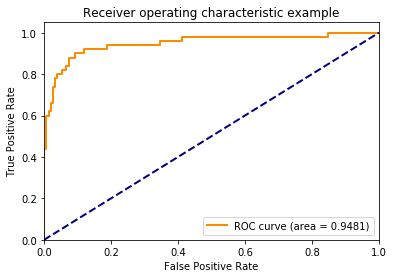

In [41]:
# ROC Curve for data validation 
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_validationLR, y_scoreLR)
roc_auc = auc(fpr, tpr) 


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Prepare the solution

### Test Set Setting for Subreddit Analysis

In [48]:
test_data = pd.read_csv("data/test_data.csv", encoding="utf8")

In [49]:
features_dict = {}

for author, group in test_data.groupby('author'):
    features_dict[author] = extract_features(group)

In [50]:
X_test = sparse.vstack([features_dict[author] for author in test_data.author.unique()])
X_test

<15000x3468 sparse matrix of type '<class 'numpy.float64'>'
	with 144898 stored elements in Compressed Sparse Row format>

In [51]:
y_predSub = model.predict_proba(X_test)[:,1]

In [52]:
solution = pd.DataFrame({"author":test_data.author.unique(), "genderSub":y_predSub})

#### Combining w2v, tfidf and sparse (author + subreddit) matrix 

In [53]:
ProbTfIdf = pd.read_csv('solutionTfIdf.csv', index_col = 0 )

In [54]:
solution['genderTfIdf'] = ProbTfIdf.ProbTfIdf 

In [55]:
ProbW2V = pd.read_csv('solutionW2V.csv', index_col = 0 )

In [56]:
solution['genderW2V'] = ProbW2V.W2VGender

In [57]:
ProbW2VAug = pd.read_csv('solutionW2VAug.csv', index_col = 0 )

In [58]:
solution['genderW2VAug'] = ProbW2VAug.W2VAugGender

In [59]:
solution.head()

,author,genderSub,genderTfIdf,genderW2V,genderW2VAug
0,ejchristian86,0.999281,0.639294,0.378125,0.556254
1,ZenDragon,0.007283,0.012001,0.107748,0.108947
2,savoytruffle,0.047766,0.010682,0.239868,0.312151
3,hentercenter,0.019414,0.086011,0.287511,0.398300
4,rick-o-suave,0.351151,0.156351,0.119092,0.142759


In [60]:
x_testLR = solution.iloc[:, 1:4]

In [61]:
y_testLR = lrClf.predict_proba(x_testLR)[:,1] #applico laregressione lineare

#### preparo la submission

In [62]:
submissionFinal = pd.DataFrame({"author":test_data.author.unique(), "gender":y_testLR})


In [63]:
submissionFinal.to_csv("submission.csv", index=False)

In [64]:
submissionFinal.head()

,author,gender
0,ejchristian86,0.902979
1,ZenDragon,0.027953
2,savoytruffle,0.039403
3,hentercenter,0.043312
4,rick-o-suave,0.140905
